In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import os
import sys
import time
import anno_func, json
import random
import copy
from collections import Counter
from math import fabs
from PIL import Image
import pandas as pd
from IPython.display import display

%matplotlib inline

In [16]:
datadir = "../data"

filedir = os.path.join(datadir,"valid_target.json")
TT100K_dir=os.path.join(datadir,"TT100K_target.json")
oannos=json.loads(open(TT100K_dir).read())
annos = json.loads(open(filedir).read())

results_annos0=json.loads(open(os.path.join(datadir, "TT100K_predict.json")).read())
result_anno_file =  os.path.join(datadir, "resnet50_predict.json")
results_annos1 = json.loads(open(result_anno_file).read())

result_anno_file=os.path.join(datadir,"resnet101_predict.json")
results_annos2=json.loads(open(result_anno_file).read())

result_anno_file=os.path.join(datadir,"resnet152_predict.json")
results_annos3=json.loads(open(result_anno_file).read())

In [27]:
print (len(results_annos1['imgs']))
sm = anno_func.eval_annos(annos, results_annos1, iou=0.5,types=anno_func.type42,minscore=50,check_type=False,minboxsize=96, maxboxsize=400)
print sm['report']

7369
iou:0.5, size:[96,400), types:none, accuracy:0.924548352816, recall:0.790909090909


In [31]:
print (len(results_annos2['imgs']))
sm = anno_func.eval_annos(annos, results_annos2, iou=0.5,types=anno_func.type42,minscore=50,check_type=True,minboxsize=96, maxboxsize=400)
print sm['report']

7369
iou:0.5, size:[96,400), types:[pl120, ...total 42...], accuracy:0.904008438819, recall:0.779090909091


In [36]:
print (len(results_annos3['imgs']))
sm = anno_func.eval_annos(annos, results_annos3, iou=0.5,types=anno_func.type42,minscore=50,check_type=True,minboxsize=0,maxboxsize=32)
print sm['report']

7369
iou:0.5, size:[0,32), types:[pl120, ...total 42...], accuracy:0.868584180511, recall:0.865365612648


In [38]:
print (len(results_annos0['imgs']))
sm = anno_func.eval_annos(oannos, results_annos0, iou=0.5,types=anno_func.type42,minscore=50,check_type=True,minboxsize=96, maxboxsize=400)
print sm['report']

3071
iou:0.5, size:[96,400), types:[pl120, ...total 42...], accuracy:0.921568627451, recall:0.880403458213


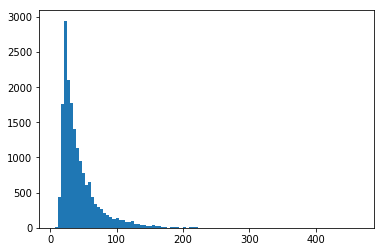

In [18]:
sizes = [ anno_func.box_long_size(obj['bbox']) for k,img in annos['imgs'].items() for obj in img['objects']]
_ = pl.hist(sizes, bins=100)

In [32]:
reload(anno_func)
df=pd.DataFrame(index=['Precision','Recall'])
#test_annos = res_annos2
#minscore=0.5
test_annos = results_annos2
minscore=50

sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=anno_func.type42,
                         minboxsize=0,maxboxsize=400,minscore=minscore)
print sm['report']
sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=anno_func.type42,
                         minboxsize=0,maxboxsize=32,minscore=minscore)
print sm['report']
sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=anno_func.type42,
                         minboxsize=32,maxboxsize=96,minscore=minscore)
print sm['report']
sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=anno_func.type42,
                         minboxsize=96,maxboxsize=400,minscore=minscore)
print sm['report']

for tp in anno_func.type42:
    sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=[tp],minscore=minscore)
    print(sm['report'])
    

99 99.9894738197 iou:0.5, size:[0,400), types:[pl120, ...total 42...], accuracy:1.0, recall:5.68117259402e-058777411715                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

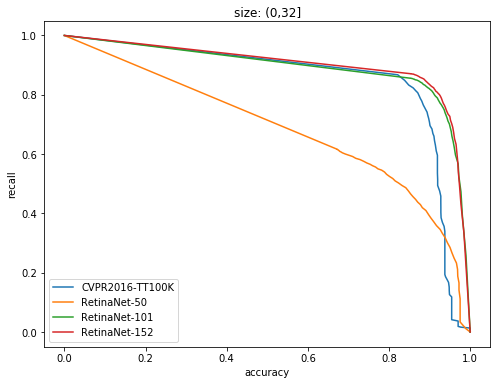

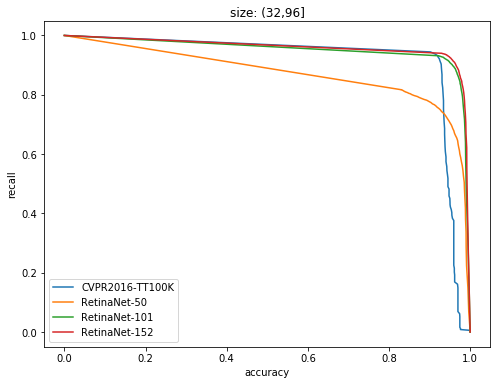

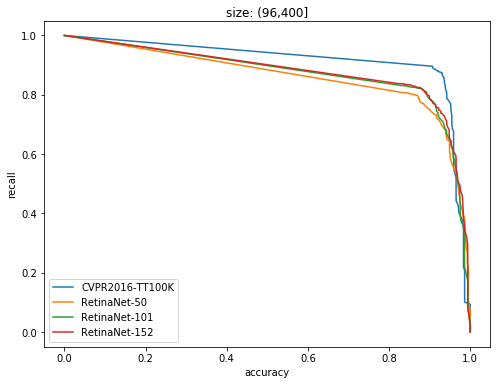

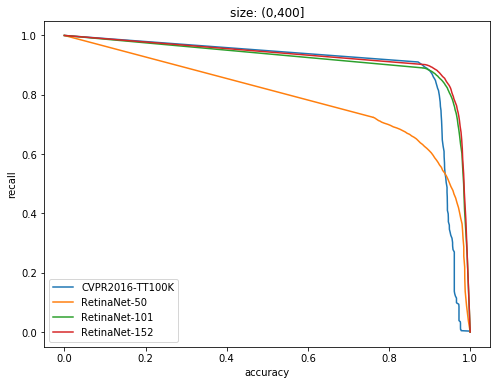

In [22]:
reload(anno_func)
def get_acc_res(results_annos, annos,**argv):
    scs = [ obj['score'] for k,img in results_annos['imgs'].items() for obj in img['objects']]
    scs = sorted(scs)
    accs = [0]
    recs = [1]
    for i, score in enumerate(np.linspace(0, scs[-1], 100)):
        sm = anno_func.eval_annos(annos, results_annos, iou=0.5, check_type=True, types=anno_func.type42, minscore=score, **argv)
        print "\r%s %s %s" % (i, score, sm['report']), 
        sys.stdout.flush()
        accs.append(sm['accuracy'])
        if len(accs)>=2 and accs[-1]<accs[-2]:
            accs[-1] = accs[-2]
        recs.append(sm['recall'])
    accs.append(1)
    recs.append(0)
    return accs, recs
sizes = [0,32,96,400]
ac_rc = []

for i in range(4):
    if i==3:
        l=sizes[0]
        r=sizes[-1]
    else:
        l=sizes[i]
        r=sizes[i+1]
    acc0, recs0=get_acc_res(results_annos0, oannos, minboxsize=l, maxboxsize=r)
    acc1, recs1 = get_acc_res(results_annos1, annos, minboxsize=l, maxboxsize=r)
    acc2, recs2 = get_acc_res(results_annos2, annos, minboxsize=l, maxboxsize=r)
    acc3, recs3=get_acc_res(results_annos3, annos, minboxsize=l, maxboxsize=r)
    ac_rc.append([acc0, recs0, acc1, recs1, acc2, recs2,acc3, recs3])
    
    pl.figure(figsize=(8,6))
    plt.plot(acc0, recs0, label='CVPR2016-TT100K')
    pl.plot(acc1, recs1, label='RetinaNet-50')
    pl.plot(acc2, recs2, label='RetinaNet-101')
    pl.plot(acc3, recs3, label='RetinaNet-152')
    pl.xlabel("accuracy")
    pl.ylabel("recall")
    pl.title("size: (%s,%s]"%(l,r))

    pl.legend(bbox_to_anchor=(0, 0), loc="lower left")

In [23]:
def compute_AP(acc, res):
    AP=0
    for i in range(1,len(acc)):
        AP+=fabs(res[i]-res[i-1])*0.5*(acc[i-1]+acc[i])
    return AP

In [24]:
MAP0=compute_AP(acc0, recs0)
MAP1=compute_AP(acc1, recs1)
MAP2=compute_AP(acc2, recs2)
MAP3=compute_AP(acc3, recs3)
print('CVPR2016-TT100K','MAP: ',MAP0)
print('RetinaNet-50', 'MAP: ',MAP1)
print('RetinaNet-101', 'MAP: ',MAP2)
print('RetinaNet=152','MAP: ', MAP3)

('CVPR2016-TT100K', 'MAP: ', 0.8979612288309989)
('RetinaNet-50', 'MAP: ', 0.7939715467764744)
('RetinaNet-101', 'MAP: ', 0.9203999564707641)
('RetinaNet=152', 'MAP: ', 0.9280140935583158)


In [46]:
df=pd.read_excel('../data/AP.xlsx')
display(df)

,CVPR-2016 TT100K,RetinaNet-50,RetinaNet-101,RetinaNet-152
MAP,0.8979,0.7939,0.9203,0.928
